In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.monitors import Monitor
from bindsnet.network.topology import Connection
from bindsnet.learning import PostPre
from tqdm import tqdm
from sklearn.metrics import f1_score
import time
from bindsnet.analysis.plotting import plot_spikes
from bindsnet.encoding import PoissonEncoder
from bindsnet.network.monitors import Monitor

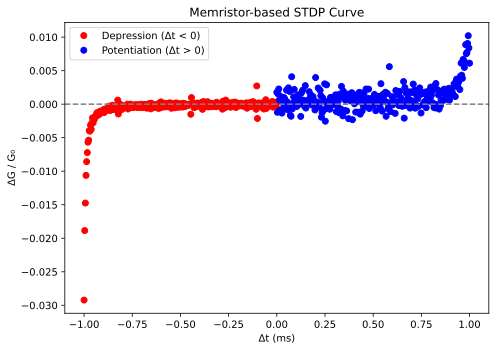

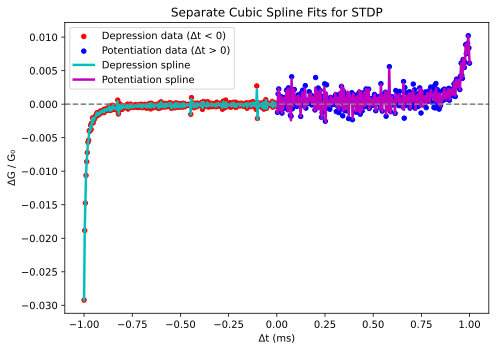

In [2]:
%run SADP_functions.ipynb

In [3]:
# Parameters
n_hidden = 400
time_window = 10  # ms
stdp_epochs = 10    # Number of epochs for STDP training
batch_size = 64
num_classes = 10


# --- Build Network ---
net = Network()

input_layer = Input(n=784, traces=True)
hidden_layer = LIFNodes(n=n_hidden, traces=True)

w = 0.3 * torch.rand(784, n_hidden)
connection = Connection(
    source=input_layer,
    target=hidden_layer,
    w=w,
    update_rule=PostPre,
    nu=(1e-4, 1e-2),
    wmin=0.0,
    wmax=1.0,
)

net.add_layer(input_layer, name='Input')
net.add_layer(hidden_layer, name='Hidden')
net.add_connection(connection, source='Input', target='Hidden')

# --- Monitor Spikes ---
spike_monitor = Monitor(obj=hidden_layer, state_vars=['s'], time=time_window)
net.add_monitor(monitor=spike_monitor, name='spikes')

# --- Custom Rate Encoder ---
class RateEncoder:
    def __init__(self, time):
        self.time = time

    def __call__(self, data):
        if not isinstance(data, torch.Tensor):
            data = torch.from_numpy(np.array(data))
        data = data.float() / 255.0
        data = data.view(-1)  # Flatten to 784
        return data.unsqueeze(0).repeat(self.time, 1)
    
encoder = RateEncoder(time=time_window)

# --- Feature Extraction ---
def extract_features(dataset, net, encoder, monitor, time, n_samples, learning=False):
    features = []
    labels = []
    
    # Set learning flag for the network
    net.learning = learning

    # Create progress bar
    progress_bar = tqdm(enumerate(dataset), total=n_samples, 
                        desc="Extracting features", unit="sample")
    
    for i, (image, label) in progress_bar:
        if i >= n_samples:
            break

        encoded = encoder(image)
        monitor.reset_state_variables()
        net.reset_state_variables()
        
        # Run network
        net.run(inputs={'Input': encoded}, time=time)
        
        spikes = monitor.get('s')
        spike_counts = spikes.sum(dim=0).numpy()
        features.append(spike_counts)
        labels.append(label)

        # Optional: Update postfix with memory usage
        if i % 100 == 0:
            progress_bar.set_postfix({
                'mem': f"{np.array(features).nbytes/1e6:.1f}MB",
                'spikes': f"{spike_counts.mean():.1f}"
            })

    return np.stack(features), np.array(labels)

# Load FMNIST dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=None)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=None)

# Use full datasets
n_train = len(train_dataset)
n_test = len(test_dataset)

# --- STDP Training ---
print(f"\nStarting STDP training for {stdp_epochs} epochs...")
start_time = time.time()

total_time=0

for epoch in range(stdp_epochs):
    epoch_start = time.time()
    print(f"\nSTDP Epoch {epoch+1}/{stdp_epochs}")
    
    # Enable learning for STDP phase
    net.learning = True
    train_features, train_labels = extract_features(
        train_dataset, net, encoder, spike_monitor, time_window, n_train, learning=True
    )
    
    # Print weight statistics
    weights = net.connections[('Input', 'Hidden')].w
    print(f"  Weight stats - Min: {weights.min():.4f}, Max: {weights.max():.4f}, Mean: {weights.mean():.4f}")
    
    epoch_time = time.time() - epoch_start
    total_time=total_time + epoch_time
    print(f"  Epoch time: {epoch_time:.2f}s")


Starting STDP training for 10 epochs...

STDP Epoch 1/10


Extracting features:  76%|███████████████████▋      | 45352/60000 [34:21<10:52, 22.46sample/s, mem=145.0MB, spikes=2.0]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Extracting features:  68%|█████████████████▋        | 40752/60000 [29:51<13:56, 23.01sample/s, mem=130.2MB, spikes=2.0]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Extracting features: 100%|██████████████████████████| 60000/60000 [44:03<00:00, 22.69sample/s, mem=191.7MB, spikes=2.0]


  Weight stats - Min: 0.9998, Max: 1.0000, Mean: 0.9999
  Epoch time: 2644.07s


In [4]:
# --- Feature Extraction ---
print("\nExtracting final features...")
# Disable learning for feature extraction
net.learning = False
train_features, train_labels = extract_features(
    train_dataset, net, encoder, spike_monitor, time_window, n_train, learning=False
)
test_features, test_labels = extract_features(
    test_dataset, net, encoder, spike_monitor, time_window, n_test, learning=False
)


Extracting final features...


Extracting features:  98%|████████████████████████▌| 59054/60000 [04:44<00:04, 198.65sample/s, mem=188.8MB, spikes=2.0]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [5]:
train_features = np.reshape(train_features,(train_features.shape[0], train_features.shape[2]))
test_features = np.reshape(test_features,(test_features.shape[0], test_features.shape[2]))

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score

In [7]:
y_train_oh = to_categorical(train_labels, num_classes)
y_test_oh = to_categorical(test_labels, num_classes)

# --- Build classifier ---
model = Sequential([
    Input(shape=(400,)),  # 400-dimensional input from SNN features
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# --- Compile model ---
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train model ---
model.fit(train_features, y_train_oh, epochs=100, batch_size=64, validation_split=0.1, verbose=2)

# --- Evaluate model ---
y_pred_prob = model.predict(test_features)
y_pred = np.argmax(y_pred_prob, axis=1)

# --- Compute metrics ---
acc = accuracy_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred, average='macro')

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Macro F1 Score: {f1:.4f}")


Epoch 1/100
844/844 - 3s - loss: 2.3211 - accuracy: 0.0986 - val_loss: 2.3027 - val_accuracy: 0.0973 - 3s/epoch - 4ms/step
Epoch 2/100
844/844 - 2s - loss: 2.3027 - accuracy: 0.0966 - val_loss: 2.3027 - val_accuracy: 0.0985 - 2s/epoch - 2ms/step
Epoch 3/100
844/844 - 2s - loss: 2.3027 - accuracy: 0.1001 - val_loss: 2.3028 - val_accuracy: 0.0925 - 2s/epoch - 2ms/step
Epoch 4/100
844/844 - 2s - loss: 2.3027 - accuracy: 0.0999 - val_loss: 2.3027 - val_accuracy: 0.0942 - 2s/epoch - 2ms/step
Epoch 5/100
844/844 - 2s - loss: 2.3027 - accuracy: 0.0983 - val_loss: 2.3028 - val_accuracy: 0.0985 - 2s/epoch - 2ms/step
Epoch 6/100
844/844 - 2s - loss: 2.3027 - accuracy: 0.0987 - val_loss: 2.3028 - val_accuracy: 0.0942 - 2s/epoch - 2ms/step
Epoch 7/100
844/844 - 2s - loss: 2.3027 - accuracy: 0.0983 - val_loss: 2.3029 - val_accuracy: 0.0925 - 2s/epoch - 2ms/step
Epoch 8/100
844/844 - 2s - loss: 2.3027 - accuracy: 0.1007 - val_loss: 2.3028 - val_accuracy: 0.0942 - 2s/epoch - 2ms/step
Epoch 9/100
844/

In [8]:
# Extract only serializable fields for CSV
csv_row = {'Model': 'STDP', 'Coding': 'rate', 'Timesteps': 10, 'Model': '1layer', 'Accuracy': acc,'F1': f1, 'Runtime_sec': total_time}

In [11]:
import csv
csv_file = "snn_benchmarking_experiment_results.csv"
# Append to CSV immediately
with open(csv_file, mode='a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=csv_row.keys())
    writer.writerow(csv_row)